<a href="https://colab.research.google.com/github/kondrasso/DQN/blob/master/DQN_QUEUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN model for queue management in medical facility

Based on [COVID-2019](https://www.kaggle.com/iamhungundji/covid19-symptoms-checker) dataset. Basic idea: we have queue of fixed lenght that represents emergency room in hospital, that filled up with patients with different sympotms and levels of severity of their condition. Our goal is to minimize waiting time while delivering help for the most severe patients.  


Before we start, we need to install external libraries, that are not present in Colab by default: 


*   Stable_baselines - library that extends OpenAI Gym and provides tool for testing correctness of constructed model in terms of Gym API
*   TensorFlow 1.13.2 - due to some constraints of Stable_baselines and OpenAI Gym we will be using this particular version of TF, which allows us to use all variants of baseline RL algorithms



In [43]:
!pip install stable_baselines[mpi]

In [44]:
!pip install 'tensorflow==1.13.2'

Now we can load our data and select necessary feautres. Weights of features at first were determined by RandomForest and manually tuned then. 

In [45]:
import pandas as pd
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange
from scipy.stats import mode
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, InputLayer
from keras.optimizers import Adam
from gym import spaces
from stable_baselines.common.env_checker import check_env

In [46]:
df = pd.read_csv('result_dqn.csv')

In [47]:
df.head()

,Unnamed: 0,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60+,dead_prob
0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0.040684
1,1,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0.052284
2,2,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0.090927
3,3,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0.042939
4,4,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0.070551


In [48]:
df['time'] = 0

In [49]:
df = df[['time','dead_prob', 'Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing',
       'Sore-Throat', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea',
       'Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']]

Feature weight vector

In [50]:
feature_w = np.array(
                      [
                        2,
                        0.12333333,
                        0.08333333,
                        0.14333333,
                        0.06333333,
                        0.19,
                        0.04,
                        0.02666667,
                        0.05,
                        0.01,
                        0.01,
                        0.1,
                        0.00666667,
                        0.02 
                      ]
                     )

Now we can determine QueueModel, which contains methods:


*   Action - represents an action-space, action from which agent should take in each step of the game. They are determined by discrete space that consists of 4 possible actions: we can remove last patient in a queue, remove most severe, patient who waited the longest time or patient with max linear combination of weighted features and time that he waiting in a queue. 
*   Upadte - method for updating queue by 1-in-1-out principle: we can remove 1 patient determined by an agent and we recive new one in the beginning of the queue.
*   Update patient severity - method that modifies severity feature value of each patient. Severity may only get worse with a time.
*   Observe - method that returns current state of queue.
*   Evaluate - function that calculates current aggregate state of all patients in queue and compares it to previous results, and difference between them determines reward that agent should recive.

CustomEnv - class that connects QueueModel and OpenAI Gym API, which allows us to use all benefits of that library: debugging, benchmark models, etc. It should contain particular methods to be considered Gym Enviroment:


*   Step - method that represents changing state of the game: agent takes action, state of the game updates, reward of the step calculated, we check if the game is over and observe new state.
*   Reset - method that can reset the game and all corresponding values
*   Get score - method that returns current state reward score

In [51]:
class QueueModel(object):
    
    def __init__(self,dataset, queue_len, feature_weights):
        self.dataset = dataset
        self.queue_len = queue_len
        self.feature_weights = feature_weights
        self.x_axis_size = self.dataset.shape[0]
        self.y_axis_size = self.dataset.shape[1]
        self.patient = None
        self.wq = None
        self.previous_step_reward = -100 # np.random.randint(70)
        self.current_step_reward = None
        self.queue = np.zeros((
                                1,
                                self.y_axis_size,
                                1
                               ),dtype=float)
        
        self.tanh = lambda x: np.tanh(x)
        self.weight_updater = lambda x: x + x*np.random.uniform(0,0.2)
        self.weighted_queue = None
        self.reward = None
        self.max_other_features = None
        self.t = 1
        self.state_space = None
        self.new_patient = None
        self.action_space = None
        self.max_wait, self.severe = None, None
        self.ep_score = []

        for i in range(self.queue_len):
            self.queue = np.vstack((
                                    self.queue,
                                    self.dataset[[np.random.randint(
                                        1,
                                        self.x_axis_size,
                                        dtype=int)],:,:]
                                    ))
            
        self.queue = np.delete(
                                self.queue,
                                -1,
                                axis=0
                               )
        
    def update_patient_severity(self):

        self.queue[:,[1],:] = self.queue[:,[0],:]+0.2*np.random.random_sample((self.queue_len,1,1))

        self.queue[:,[1],:] = np.apply_along_axis(
                                                  np.tanh,
                                                  0,
                                                  self.queue[:,[1],:]
                                                  )
        return self
    
    
    def update(self):

        self.new_patient = self.dataset[
                                        [np.random.randint(
                                                            1,
                                                            self.x_axis_size,
                                                            dtype=int)
                                        ],:,:]

        self.queue = np.vstack((
                                self.queue,
                                self.dataset[
                                             [np.random.randint(
                                                                1,
                                                                self.x_axis_size,
                                                                dtype=int
                                                                )
                                             ],:,:]
                                ))
        
        self.queue[:,[0],:] += 1
        return self
    
    def observe(self):

        return self.queue
        
    def action(self, action):

        if action == 0:
            self.max_wait = np.argmax(self.queue[:,[0],:]) 
            self.queue = np.delete(
                                    self.queue,
                                    self.max_wait,
                                    axis=0
                                   )
        elif action == 1:
            self.max_severe = np.argmax(self.queue[:,[1],:])
            self.queue = np.delete(
                                    self.queue,
                                    self.max_severe,
                                    axis=0
                                   )
        elif action == 2:
            self.queue = np.delete(
                                    self.queue,
                                    -1,
                                    axis=0
                                   )
        else:
            self.wq = self.queue.copy()

            self.wq[:,2:,[0]] = np.multiply(
                                             self.wq[:,2:,[0]],
                                             self.feature_weights.reshape(1,self.y_axis_size-2,1)
                                            )
            
            self.max_other_features = np.argmax(np.sum(self.wq[:,2:,:],axis=1))

            self.queue = np.delete(
                                    self.queue,
                                    self.max_other_features,
                                    axis=0
                                   )
        return self
    
    def evaluate(self):
        # self.weighted_queue = self.queue.copy()

        # self.weighted_queue[:,2:,:] = np.multiply(
        #                                             self.weighted_queue[:,2:,:],
        #                                             self.feature_weights.reshape(1,self.y_axis_size-2,1)
        #                                             )
        # self.update_patient_severity()
        # self.current_step_reward = 1/np.sum(np.sum(self.queue,axis=1))
        # if self.current_step_reward < self.previous_step_reward:
        #     self.reward = abs(self.previous_step_reward - self.current_step_reward)*100
        # else:
        #     self.reward = abs(self.previous_step_reward - self.current_step_reward)*10
        # self.previous_step_reward = self.current_step_reward
        # self.ep_score.append(self.current_step_reward)
        # self.reward
        return 100/np.sum(np.sum(self.queue,axis=1))
    
    def is_done(self):
        if self.t > 50: 
            return True
        else:
            return False
    


class CustomEnv(gym.Env):
    
    def __init__(self,dataset,queue_len,feature_w):
        
        self.dataset = dataset
        self.queue_len = queue_len
        self.feature_w = feature_w

        self.queue_game = QueueModel(
                                      dataset,
                                      queue_len,
                                      feature_w
                                      )
        
        self.y_axis_size = self.dataset.shape[1]
        self.action_space = spaces.Discrete(4)

        self.observation_space = spaces.Box(
                                            low=0,
                                            high=255,
                                            shape=
                                            (
                                                self.queue_len, 
                                                self.y_axis_size, 
                                                1
                                             )
                                            )

    def reset(self):

        del self.queue_game

        self.queue_game = QueueModel(
                                      self.dataset,
                                      self.queue_len,
                                      self.feature_w
                                     )
        
        return self.queue_game.queue
    
    def get_score(self):
        return self.queue_game.ep_score

    def step(self, action):

        self.queue_game.action(action)
        self.queue_game.update()
        reward = self.queue_game.evaluate()
        done = self.queue_game.is_done()
        obs = self.queue_game.observe()
        info = {}
        return obs, reward, done, info

Now we can check  correctness of our enviroment with stable baseline tool. Because it's was originally design to check image-related models, we get 2 warnings, but in our case this is ok

In [52]:
env = CustomEnv(
        df.iloc[:100000, :16].to_numpy().reshape(100000,16,1),
        5,
        feature_w
        )
# It will check your custom environment and output additional warnings if needed
check_env(env)

/usr/local/lib/python3.6/dist-packages/stable_baselines/common/env_checker.py:25: UserWarning: It seems that your observation is an image but the `dtype` of your observation_space is not `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn("It seems that your observation is an image but the `dtype` "
/usr/local/lib/python3.6/dist-packages/stable_baselines/common/env_checker.py:38: UserWarning: The minimal resolution for an image is 36x36 for the default CnnPolicy. You might need to use a custom `cnn_extractor` cf https://stable-baselines.readthedocs.io/en/master/guide/custom_policy.html
  warnings.warn("The minimal resolution for an image is 36x36 for the default CnnPolicy. "


Now we can determine our DQN agent that can take actions and make the decisions. It's structure are pretty straightforward, it's better that you look up basics in this [tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

As for our parameters: our state space determined by matrix with dimensions QUEUE x 16 x 1; three dimensional matrix considered because of inherit traits of DQN RL models. We are training on the first 100k patients, which are roughly 30% of all data. 

In [53]:
EPISODES = 1000
QUEUE = 10
BATCH_SIZE = 32

temp_reward_mean = []
temp_actions_moda = []
ep = []

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(InputLayer(input_shape=(16,1)))
        model.add(Dense(self.state_size*QUEUE, activation='elu'))
        model.add(Dense(self.state_size*QUEUE, activation='elu'))
        model.add(Dense(self.state_size*QUEUE, activation='elu'))
        model.add(Dense(self.state_size*QUEUE, activation='elu'))
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append(
            (
              state,
              action,
              reward,
              next_state,
              done
            )
        )

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)

            target_f[0][action] = target
            self.model.fit(
                  state,
                  target_f,
                  epochs=1,
                  verbose=0
                )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

Now we can run training routine episode-wise, using our CustomEnv and DQNAgent. We do not replay entire episodes for a few times because of computational complexity. 


In [54]:
if __name__ == "__main__":
    env = CustomEnv(
        df.iloc[:100000, :16].to_numpy().reshape(100000,16,1),
        QUEUE,
        feature_w
        )
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    done = False
    batch_size = BATCH_SIZE

    for e in tqdm(range(EPISODES)):
        state = env.reset()
        mean_reward = []
        actions = []
        for time in range(1):
            action = agent.act(state)
            actions.append(action)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -100
            mean_reward.append(reward)
            agent.memorize(
                state,
                action,
                reward,
                next_state,
                done
                )
            state = next_state
            if done:
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(
                          e,
                          EPISODES,
                          time,
                          agent.epsilon
                          )
                      )
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        temp_reward_mean.append(np.mean(mean_reward))
        temp_actions_moda.append(int(mode(actions)[0]))

        ep.extend(env.get_score())

So, now when we finished training we can see the result - it's kinda started to converge, but we need a lot more computational power to determine if it's possible.


Text(0, 0.5, 'Mean reward')

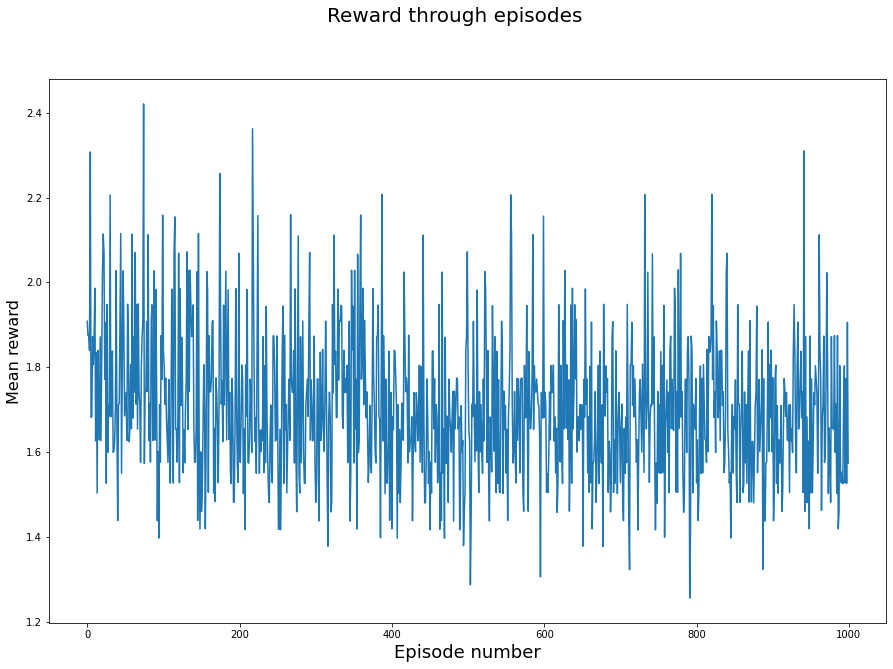

In [80]:
fig = plt.figure(figsize=(15,10))
plt.plot(temp_reward_mean)
fig.suptitle('Reward through episodes', fontsize=20)
plt.xlabel('Episode number', fontsize=18)
plt.ylabel('Mean reward', fontsize=16)

RL is quite interesting in sense that we can try to determine policy that we can apply to a variety of situation, but it's quite heavy on computational side and it's not guaranteed that in counstructed enviroment even exists some semblence of sub-optimal stategy. 